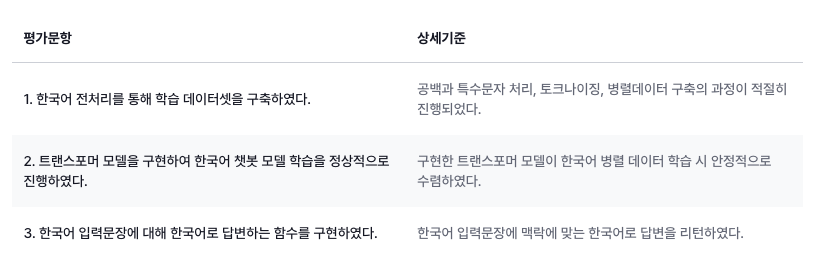

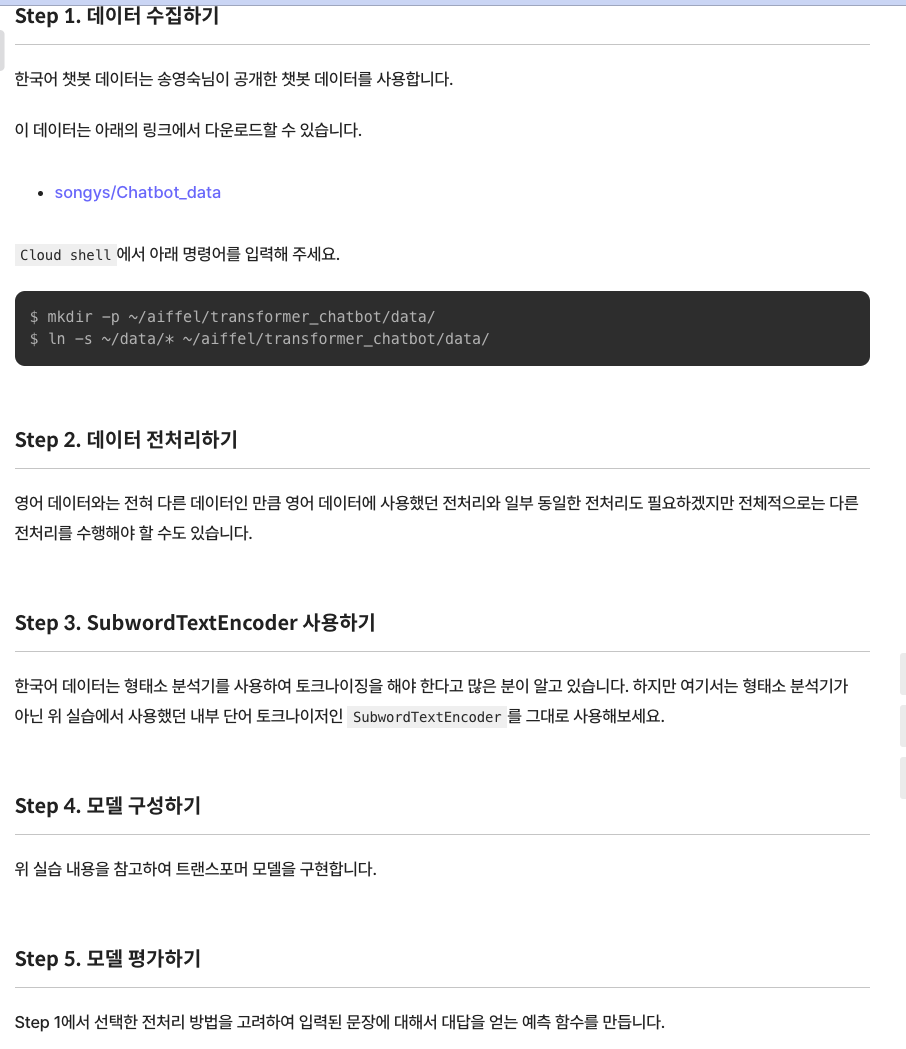


# 트랜스포머로 만드는 대화형 챗봇

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras_tuner as kt

## 1.데이터 가져오기 

In [2]:
current_path = os.getcwd()
print(f"현재 경로: {current_path}")

현재 경로: /aiffel/aiffel/transformer_chatbot


In [3]:
!mkdir -p /transformer_chatbot/data/
!ln -s ~/data/* /transformer_chatbot/data/

ln: failed to create symbolic link '/transformer_chatbot/data/ChatbotData .csv': File exists


In [4]:
path_to_csv = '/aiffel/aiffel/transformer_chatbot/data/ChatbotData .csv'
data = pd.read_csv(path_to_csv)

In [5]:
def preprocess_sentence(sentence):
    # 문장을 소문자로 변환하고 양쪽 끝의 공백을 제거합니다.
    sentence = sentence.lower().strip()
    
    # 구두점(?.!,) 앞뒤에 공백을 추가합니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    # 연속된 공백을 하나의 공백으로 대체합니다.
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # 한글, 영어, 구두점(?.!,)을 제외한 모든 문자를 공백으로 대체합니다.
    sentence = re.sub(r"[^ㄱ-ㅎ가-힣a-zA-Z?.!,]+", " ", sentence)
    
    # 양쪽 끝의 공백을 제거합니다.
    sentence = sentence.strip()
    
    return sentence

## 2.데이터 전처리

In [6]:
max_samples = 50000  # 최대 샘플 수를 50,000으로 설정

def load_conversations():
    
    # 질문과 답변 데이터 추출 및 전처리
    inputs, outputs = [], []  # 입력과 출력 리스트 초기화
    for index, row in data.iterrows():  # 데이터프레임의 각 행을 반복
        inputs.append(preprocess_sentence(row['Q']))  # 질문을 전처리하여 inputs 리스트에 추가
        outputs.append(preprocess_sentence(row['A']))  # 답변을 전처리하여 outputs 리스트에 추가
        
        if len(inputs) >= max_samples:  # 입력 리스트의 길이가 최대 샘플 수를 초과하면
            break  # 반복문 종료

    return inputs, outputs  # 입력과 출력 리스트 반환

In [7]:
# load_conversations 함수를 호출하여 질문과 답변 데이터를 불러옵니다.
questions, answers = load_conversations()
questions_train, questions_val, answers_train, answers_val = train_test_split(questions, answers, test_size=0.2, random_state=42)

# 불러온 질문 데이터의 전체 샘플 수를 출력합니다.
print('전체 샘플 수 :', len(questions))

# 불러온 답변 데이터의 전체 샘플 수를 출력합니다.
print('전체 샘플 수 :', len(answers))

print(f"훈련 데이터 크기: {len(questions_train)}")
print(f"검증 데이터 크기: {len(questions_val)}")

전체 샘플 수 : 11823
전체 샘플 수 : 11823
훈련 데이터 크기: 9458
검증 데이터 크기: 2365


In [8]:
print(f"훈련 데이터 크기: {len(answers_train)}")
print(f"검증 데이터 크기: {len(answers_val)}")

훈련 데이터 크기: 9458
검증 데이터 크기: 2365


In [9]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))
print('전처리 후의 22번째 질문 샘플: {}'.format(questions_train[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers_train[21]))
print('전처리 후의 22번째 질문 샘플: {}'.format(questions_val[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers_val[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .
전처리 후의 22번째 질문 샘플: 썸타는거 친구한테 이야기 한고 싶다 .
전처리 후의 22번째 답변 샘플: 확실해지면 이야기해도 늦지 않아요 .
전처리 후의 22번째 질문 샘플: 완벽해지는 방법
전처리 후의 22번째 답변 샘플: 완벽한 사람은 없고 완벽할 수도 없어요 .


## 3.SubwordTextEncoder 사용하기

In [10]:
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary(어휘 집합) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers,  # 질문과 답변 데이터를 합쳐서 어휘 집합을 만듦
    target_vocab_size=2**13  # 목표 어휘 집합 크기를 8192(2의 13승)로 설정
)

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐


In [11]:
# 시작 토큰과 종료 토큰을 정의
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]  
# START_TOKEN은 어휘 집합의 크기(새로운 토큰의 인덱스)를 사용
# END_TOKEN은 어휘 집합의 크기보다 1 큰 값(새로운 토큰의 인덱스)을 사용

In [12]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8135]
END_TOKEN의 번호 : [8136]


In [13]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8137


In [14]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5744, 610, 2485, 4149]
정수 인코딩 후의 21번째 답변 샘플: [2353, 7486, 7, 6252, 97, 1]


In [15]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [16]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []  # 토큰화된 입력과 출력을 저장할 리스트 초기화
  
  for (sentence1, sentence2) in zip(inputs, outputs):  # 입력과 출력 데이터를 쌍으로 묶어 반복
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)  # 조건을 만족하는 입력 문장을 토큰화된 입력 리스트에 추가
      tokenized_outputs.append(sentence2)  # 조건을 만족하는 출력 문장을 토큰화된 출력 리스트에 추가
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs  # 토큰화되고 패딩된 입력과 출력 반환

In [17]:
# 질문과 답변 데이터를 토큰화하고 필터링합니다.
questions, answers = tokenize_and_filter(questions, answers)
# 훈련 및 검증 데이터셋 토크나이징 및 패딩
train_inputs, train_outputs = tokenize_and_filter(questions_train, answers_train)
val_inputs, val_outputs = tokenize_and_filter(questions_val, answers_val)

# 단어장의 크기를 출력합니다.
print('단어장의 크기 :', (VOCAB_SIZE))

# 필터링 후의 질문 샘플 개수를 출력합니다.
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))

# 필터링 후의 답변 샘플 개수를 출력합니다.
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))
# 필터링 후의 질문 샘플 개수를 출력합니다.
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions_train)))

# 필터링 후의 답변 샘플 개수를 출력합니다.
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers_train)))
# 필터링 후의 질문 샘플 개수를 출력합니다.
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions_val)))

# 필터링 후의 답변 샘플 개수를 출력합니다.
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers_val)))

단어장의 크기 : 8137
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823
필터링 후의 질문 샘플 개수: 9458
필터링 후의 답변 샘플 개수: 9458
필터링 후의 질문 샘플 개수: 2365
필터링 후의 답변 샘플 개수: 2365


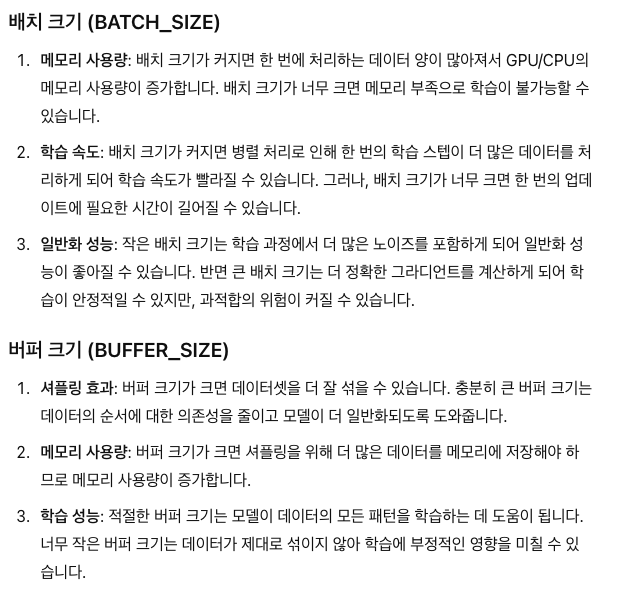

In [18]:
BATCH_SIZE = 64  # 배치 크기를 64로 설정
BUFFER_SIZE = 20000  # 버퍼 크기를 20000으로 설정

# 훈련 데이터셋 생성
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': train_inputs,
        'dec_inputs': train_outputs[:, :-1]
    },
    {
        'outputs': train_outputs[:, 1:]
    }
))

# 검증 데이터셋 생성
val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': val_inputs,
        'dec_inputs': val_outputs[:, :-1]
    },
    {
        'outputs': val_outputs[:, 1:]
    }
))



# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,  # 입력 데이터는 questions
        'dec_inputs': answers[:, :-1]  # 디코더 입력 데이터는 answers에서 마지막 토큰을 제외한 것
    },
    {
        'outputs': answers[:, 1:]  # 출력 데이터는 answers에서 첫 번째 토큰을 제외한 것
    },
))

dataset = dataset.cache()  # 데이터셋을 캐싱하여 성능 향상
dataset = dataset.shuffle(BUFFER_SIZE)  # 데이터셋을 섞어 버퍼 크기만큼의 데이터로 섞음
dataset = dataset.batch(BATCH_SIZE)  # 배치 크기만큼 데이터셋을 나눔
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)  # 데이터를 미리 가져와서 학습 속도 향상

train_dataset = train_dataset.cache()  # 데이터셋을 캐싱하여 성능 향상
train_dataset = train_dataset.shuffle(BUFFER_SIZE)  # 데이터셋을 섞어 버퍼 크기만큼의 데이터로 섞음
train_dataset = train_dataset.batch(BATCH_SIZE)  # 배치 크기만큼 데이터셋을 나눔
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)  # 데이터를 미리 가져와서 학습 속도 향상
val_dataset = val_dataset.cache()  # 데이터셋을 캐싱하여 성능 향상
val_dataset = val_dataset.shuffle(BUFFER_SIZE)  # 데이터셋을 섞어 버퍼 크기만큼의 데이터로 섞음
val_dataset = val_dataset.batch(BATCH_SIZE)  # 배치 크기만큼 데이터셋을 나눔
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)  # 데이터를 미리 가져와서 학습 속도 향상

## 모델구성


In [19]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)  # 포지셔널 인코딩을 생성

  def get_angles(self, position, i, d_model):
    # 각도를 계산하는 함수
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],  # 위치 인덱스
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],  # 모델 차원 인덱스
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]  # 배치 차원을 추가
    return tf.cast(pos_encoding, tf.float32)  # float32로 캐스팅

  def call(self, inputs):
    # 입력에 포지셔널 인코딩을 더해 반환
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


In [20]:
# 마스킹 함수

def create_padding_mask(x):
  # 패딩 마스크 생성: 입력 x에서 0인 위치를 찾아 마스크를 생성
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)의 형태로 반환
  return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(x):
  # 시퀀스 길이를 가져옴
  seq_len = tf.shape(x)[1]
  # Look-ahead 마스크 생성: 하삼각 행렬을 만들어 미래의 토큰을 가림
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  # 패딩 마스크 생성
  padding_mask = create_padding_mask(x)
  # look_ahead_mask와 padding_mask 중 큰 값을 선택하여 반환
  return tf.maximum(look_ahead_mask, padding_mask)



In [21]:
# 스케일된 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트로 계산
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화 (스케일링)
  depth = tf.cast(tf.shape(key)[-1], tf.float32)  # key의 마지막 차원을 depth로 설정
  logits = matmul_qk / tf.math.sqrt(depth)  # 가중치를 depth의 제곱근으로 나눔

  # 패딩에 마스크 추가 (마스크가 있으면)
  if mask is not None:
    logits += (mask * -1e9)  # 마스크된 위치에 큰 음수를 더하여 softmax 결과가 0에 가까워지도록 함

  # softmax를 적용하여 어텐션 가중치 계산
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션 출력은 어텐션 가중치와 V의 닷 프로덕트로 계산
  output = tf.matmul(attention_weights, value)
  return output

In [22]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads  # 머리의 수 (병렬 처리할 어텐션 수)
    self.d_model = d_model  # 모델 차원

    assert d_model % self.num_heads == 0  # d_model이 num_heads로 나누어 떨어지는지 확인

    self.depth = d_model // self.num_heads  # 각 머리의 차원 수

    # Q, K, V를 위한 밀집 레이어 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # 최종 출력 밀집 레이어 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    # 입력을 (batch_size, num_heads, seq_len, depth) 형태로 변환
    inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])  # 축 변경

  def call(self, inputs):
    # 입력에서 query, key, value, mask 추출
    query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듦
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수 적용
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    # 어텐션 결과를 다시 (batch_size, seq_len, num_heads, depth) 형태로 변환
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)
    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용
    outputs = self.dense(concat_attention)

    return outputs


In [23]:
# 인코더 레이어 정의
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  # 입력 텐서 정의
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어: 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,  # 쿼리
          'key': inputs,    # 키
          'value': inputs,  # 값
          'mask': padding_mask  # 패딩 마스크
      })

  # 어텐션의 결과에 Dropout과 Layer Normalization 적용
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)  # 드롭아웃 적용
  attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)  # 레이어 정규화 적용

  # 두 번째 서브 레이어: 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)  # 첫 번째 완전연결층 (ReLU 활성화 함수 사용)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)  # 두 번째 완전연결층

  # 완전연결층의 결과에 Dropout과 Layer Normalization 적용
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)  # 드롭아웃 적용
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)  # 레이어 정규화 적용

  # 모델 반환
  return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 인코더 정의
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
  # 입력 텐서 정의
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)  # 입력을 임베딩
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))  # 임베딩 값을 스케일링 (d_model의 제곱근으로 나눔)

  # 포지셔널 인코딩 추가
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)  # 포지셔널 인코딩 추가

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)  # 드롭아웃 적용

  # num_layers만큼 인코더 레이어를 쌓음
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,  # 완전연결층의 유닛 수
        d_model=d_model,  # 모델 차원
        num_heads=num_heads,  # 멀티 헤드 어텐션의 헤드 수
        dropout=dropout,  # 드롭아웃 비율
        name="encoder_layer_{}".format(i),  # 레이어 이름
    )([outputs, padding_mask])

  # 모델 반환
  return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)



In [24]:
# 디코더 레이어 정의
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  # 입력 텐서 정의
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어: 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask  # 미래 토큰을 마스킹하여 셀프 어텐션
      })

  # 멀티 헤드 어텐션의 결과에 LayerNormalization 적용
  attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어: 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,  # 디코더의 셀프 어텐션 결과를 쿼리로 사용
          'key': enc_outputs,  # 인코더의 출력을 키와 값으로 사용
          'value': enc_outputs,
          'mask': padding_mask  # 패딩 토큰을 마스킹
      })

  # 마스크드 멀티 헤드 어텐션의 결과에 Dropout과 LayerNormalization 적용
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어: 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)  # 첫 번째 완전연결층
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)  # 두 번째 완전연결층

  # 완전연결층의 결과에 Dropout과 LayerNormalization 적용
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

  # 모델 반환
  return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

# 디코더 정의
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='decoder'):
  # 입력 텐서 정의
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))  # 임베딩 값을 스케일링

  # 포지셔널 인코딩 추가
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout 적용
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 디코더 레이어를 쌓음
  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,  # 완전연결층의 유닛 수
        d_model=d_model,  # 모델 차원
        num_heads=num_heads,  # 멀티 헤드 어텐션의 헤드 수
        dropout=dropout,  # 드롭아웃 비율
        name='decoder_layer_{}'.format(i),  # 레이어 이름
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  # 모델 반환
  return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)


In [25]:
# 트랜스포머 함수 정의
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"):
  # 입력 텐서 정의
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크 생성
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크하기 위한 look-ahead 마스크 생성
  # 내부적으로 패딩 마스크도 포함됨
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹하기 위한 디코더의 패딩 마스크 생성
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더 생성 및 호출
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더 생성 및 호출
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층을 통해 최종 출력 생성
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  # 모델 반환
  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## 모델학습

In [26]:
def loss_function(y_true, y_pred):
  # y_true의 형태를 (-1, MAX_LENGTH - 1)로 재구성 (예상: (batch_size, seq_len))
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  # 손실 함수 정의: SparseCategoricalCrossentropy 사용
  # from_logits=True: y_pred가 로짓(확률 분포를 거치지 않은 값)임을 명시
  # reduction='none': 개별 샘플의 손실 값을 유지 (나중에 마스크를 적용하기 위해)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  # y_true에서 0이 아닌 값들에 대해 마스크 생성
  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  
  # 손실 값에 마스크를 곱하여 패딩 토큰의 손실을 무시
  loss = tf.multiply(loss, mask)

  # 마스킹된 손실 값들의 평균을 반환
  return tf.reduce_mean(loss)

In [27]:
# 학습률 스케줄링 클래스 정의
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    # 모델 차원 d_model과 warmup_steps를 초기화
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)  # d_model을 float32 타입으로 캐스팅
    
    self.warmup_steps = warmup_steps  # 워밍업 스텝 수 초기화

  def __call__(self, step):
    # 학습률 계산: step에 따른 학습률을 반환
    
    arg1 = tf.math.rsqrt(step)  # step의 제곱근의 역수
    arg2 = step * (self.warmup_steps**-1.5)  # step과 warmup_steps의 관계 계산
    
    # 모델 차원의 제곱근의 역수와 최소값을 곱하여 학습률 반환
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


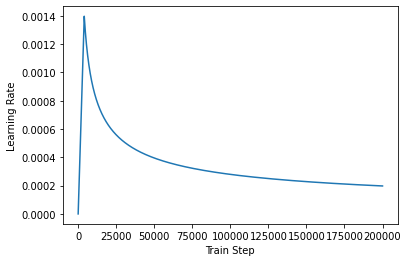

In [28]:
# CustomSchedule 클래스를 사용하여 학습률 스케줄링 예제 생성
sample_learning_rate = CustomSchedule(d_model=128)

# 200000 스텝 동안의 학습률을 계산하여 플롯
plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")  # y축 라벨 설정
plt.xlabel("Train Step")  # x축 라벨 설정
plt.show()  # 그래프를 화면에 출력


In [29]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 3 # 인코더와 디코더의 층의 개수
D_MODEL = 128 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 4 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 384 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

# 트랜스포머 모델 생성
model = transformer(
    vocab_size=VOCAB_SIZE,  # 어휘 집합의 크기
    num_layers=NUM_LAYERS,  # 인코더와 디코더의 레이어 수
    units=UNITS,  # 완전연결층의 유닛 수
    d_model=D_MODEL,  # 모델 차원
    num_heads=NUM_HEADS,  # 멀티 헤드 어텐션의 헤드 수
    dropout=DROPOUT  # 드롭아웃 비율
)

# 모델 요약 출력
model.summary()

# 최적의 하이퍼파라미터로 모델 학습

#history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[stop_early])

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 128)    1537664     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [30]:
# CustomSchedule 클래스를 사용하여 학습률 스케줄링 설정
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Nadam(
    learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

# 정확도 함수 정의
def accuracy(y_true, y_pred):
  # y_true의 형태를 (-1, MAX_LENGTH - 1)로 재구성 (예상: (batch_size, seq_len))
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  # sparse_categorical_accuracy를 계산하여 정확도 반환
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# 모델 컴파일
model.compile(
    optimizer=optimizer,  # 설정한 Adam 옵티마이저
    loss=loss_function,  # 정의한 손실 함수
    metrics=[accuracy]  # 정의한 정확도 함수
)


In [31]:
def build_model(hp):
    vocab_size = VOCAB_SIZE
    num_layers = hp.Int('num_layers', min_value=2, max_value=6, step=1)
    units = hp.Int('units', min_value=256, max_value=1024, step=128)
    d_model = hp.Int('d_model', min_value=128, max_value=512, step=128)
    num_heads = hp.Int('num_heads', min_value=4, max_value=8, step=1)
    dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    model = transformer(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout
    )
    
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
    )
    
    model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
    
    return model

In [32]:
'''tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='transformer_tuning'
)'''

"tuner = kt.Hyperband(\n    build_model,\n    objective='val_loss',\n    max_epochs=20,\n    factor=3,\n    directory='my_dir',\n    project_name='transformer_tuning'\n)"

In [33]:
# 조기 종료 콜백 추가
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


In [34]:
#tuner.search(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[stop_early])

In [35]:
'''best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
하이퍼파라미터 검색이 완료되었습니다. 최적의 레이어 수는 {best_hps.get('num_layers')}개,
유닛 수는 {best_hps.get('units')}개, d_model 값은 {best_hps.get('d_model')}개,
어텐션 헤드 수는 {best_hps.get('num_heads')}개, 드롭아웃 비율은 {best_hps.get('dropout')}이며,
학습률은 {best_hps.get('learning_rate')}입니다.
""")'''

'best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]\nprint(f"""\n하이퍼파라미터 검색이 완료되었습니다. 최적의 레이어 수는 {best_hps.get(\'num_layers\')}개,\n유닛 수는 {best_hps.get(\'units\')}개, d_model 값은 {best_hps.get(\'d_model\')}개,\n어텐션 헤드 수는 {best_hps.get(\'num_heads\')}개, 드롭아웃 비율은 {best_hps.get(\'dropout\')}이며,\n학습률은 {best_hps.get(\'learning_rate\')}입니다.\n""")'

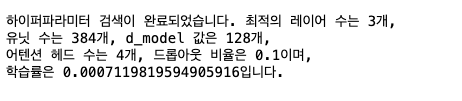


In [36]:
'''EPOCHS = 10

history = model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, verbose=1)

# 시각화 함수 정의
def plot_metrics(history):
    plt.figure(figsize=(12, 4))

    # 훈련 및 검증 손실 시각화
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')

    # 훈련 및 검증 정확도 시각화
    plt.subplot(1, 2, 2)
    plt.plot(history.history.get('accuracy', []), label='Train Accuracy')
    plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.title('Accuracy')

    plt.show()

# 시각화 함수 호출
plot_metrics(history)'''

"EPOCHS = 10\n\nhistory = model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, verbose=1)\n\n# 시각화 함수 정의\ndef plot_metrics(history):\n    plt.figure(figsize=(12, 4))\n\n    # 훈련 및 검증 손실 시각화\n    plt.subplot(1, 2, 1)\n    plt.plot(history.history['loss'], label='Train Loss')\n    plt.plot(history.history['val_loss'], label='Validation Loss')\n    plt.xlabel('Epochs')\n    plt.ylabel('Loss')\n    plt.legend(loc='upper right')\n    plt.title('Loss')\n\n    # 훈련 및 검증 정확도 시각화\n    plt.subplot(1, 2, 2)\n    plt.plot(history.history.get('accuracy', []), label='Train Accuracy')\n    plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')\n    plt.xlabel('Epochs')\n    plt.ylabel('Accuracy')\n    plt.legend(loc='upper right')\n    plt.title('Accuracy')\n\n    plt.show()\n\n# 시각화 함수 호출\nplot_metrics(history)"

Epoch 1/20
185/185 [==============================] - 26s 59ms/step - loss: 1.0958 - accuracy: 0.0450
Epoch 2/20
185/185 [==============================] - 11s 58ms/step - loss: 0.9364 - accuracy: 0.0525
Epoch 3/20
185/185 [==============================] - 11s 61ms/step - loss: 0.9097 - accuracy: 0.0535
Epoch 4/20
185/185 [==============================] - 11s 60ms/step - loss: 0.8783 - accuracy: 0.0550
Epoch 5/20
185/185 [==============================] - 11s 59ms/step - loss: 0.8570 - accuracy: 0.0557
Epoch 6/20
185/185 [==============================] - 11s 59ms/step - loss: 0.8348 - accuracy: 0.0566
Epoch 7/20
185/185 [==============================] - 11s 59ms/step - loss: 0.8088 - accuracy: 0.0583
Epoch 8/20
185/185 [==============================] - 11s 59ms/step - loss: 0.7794 - accuracy: 0.0597
Epoch 9/20
185/185 [==============================] - 11s 58ms/step - loss: 0.7434 - accuracy: 0.0615
Epoch 10/20
185/185 [==============================] - 11s 58ms/step - loss: 0.708

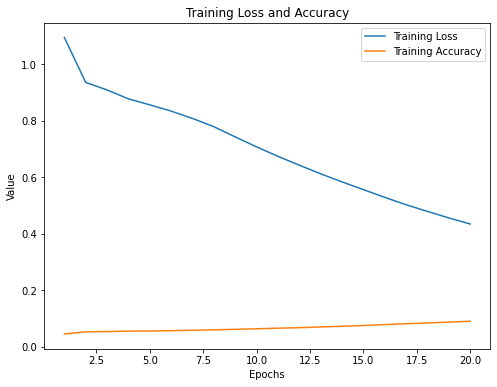

In [37]:
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS, verbose=1, callbacks=[stop_early])


def plot_metrics(history):
    plt.figure(figsize=(8, 6))

    # 손실 및 정확도 시각화
    epochs = range(1, len(history.history['loss']) + 1)

    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.title('Training Loss and Accuracy')
    plt.legend()

    plt.show()
plot_metrics(history)

In [38]:
'''def plot_metrics(history):
    plt.figure(figsize=(8, 6))

    # 손실 및 정확도 시각화
    epochs = range(1, len(history.history['loss']) + 1)

    plt.plot(epochs, history.history['loss'], label='Loss')
    plt.plot(epochs, history.history['accuracy'], label='Accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.title('Training Loss and Accuracy')
    plt.legend()

    plt.show()
plot_metrics(history)'''

"def plot_metrics(history):\n    plt.figure(figsize=(8, 6))\n\n    # 손실 및 정확도 시각화\n    epochs = range(1, len(history.history['loss']) + 1)\n\n    plt.plot(epochs, history.history['loss'], label='Loss')\n    plt.plot(epochs, history.history['accuracy'], label='Accuracy')\n\n    plt.xlabel('Epochs')\n    plt.ylabel('Value')\n    plt.title('Training Loss and Accuracy')\n    plt.legend()\n\n    plt.show()\nplot_metrics(history)"

In [39]:
def decoder_inference(sentence):
  # 입력된 문장을 전처리합니다.
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없으므로 시작 토큰만 별도로 저장. 예: [START_TOKEN]
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]  # 마지막 토큰에 대한 예측만 가져옴

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들을 지속적으로 output_sequence에 추가합니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  # 최종 예측된 시퀀스를 반환합니다. (배치 차원을 제거)
  return tf.squeeze(output_sequence, axis=0)


In [40]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])  # 어휘 집합 크기 이하의 정수들만 변환

  # 입력 문장과 출력 문장을 출력합니다.
  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence  # 예측된 문장을 반환


In [41]:
sentence_generation('날씨가 더워')

입력 : 날씨가 더워
출력 : 지금도 충분해요 .


'지금도 충분해요 .'

## 1번째 테스트

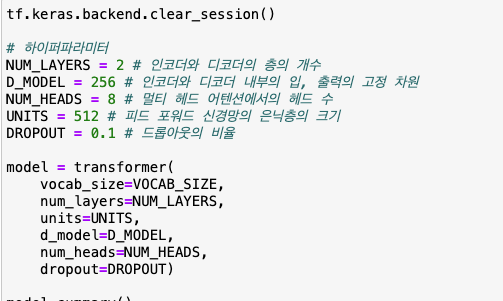
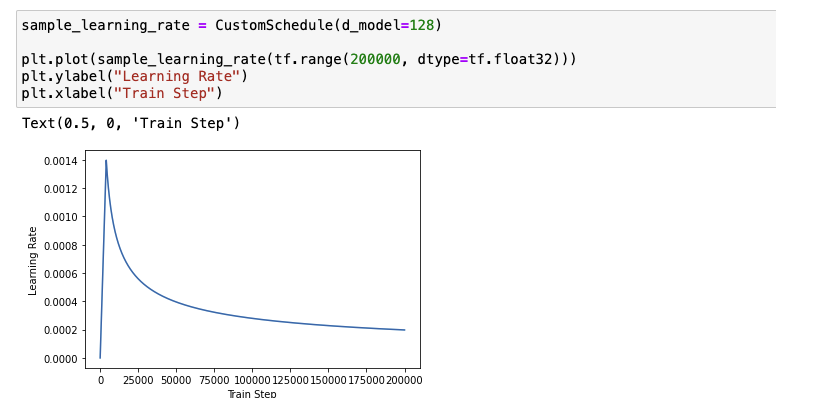
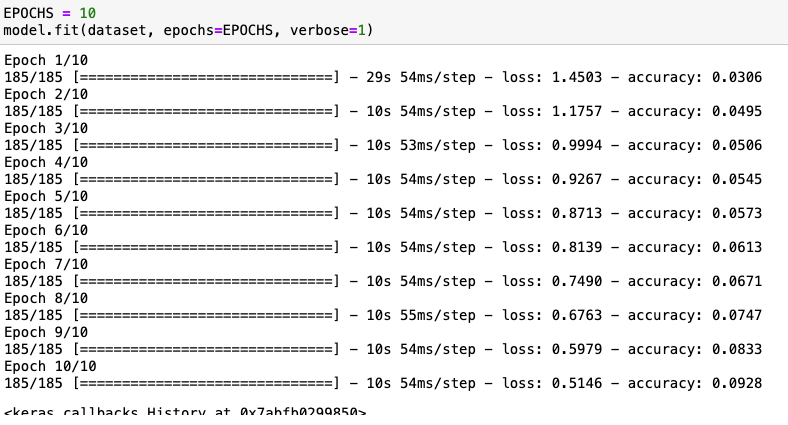

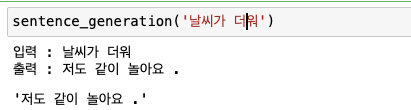

## 2번째 테스트
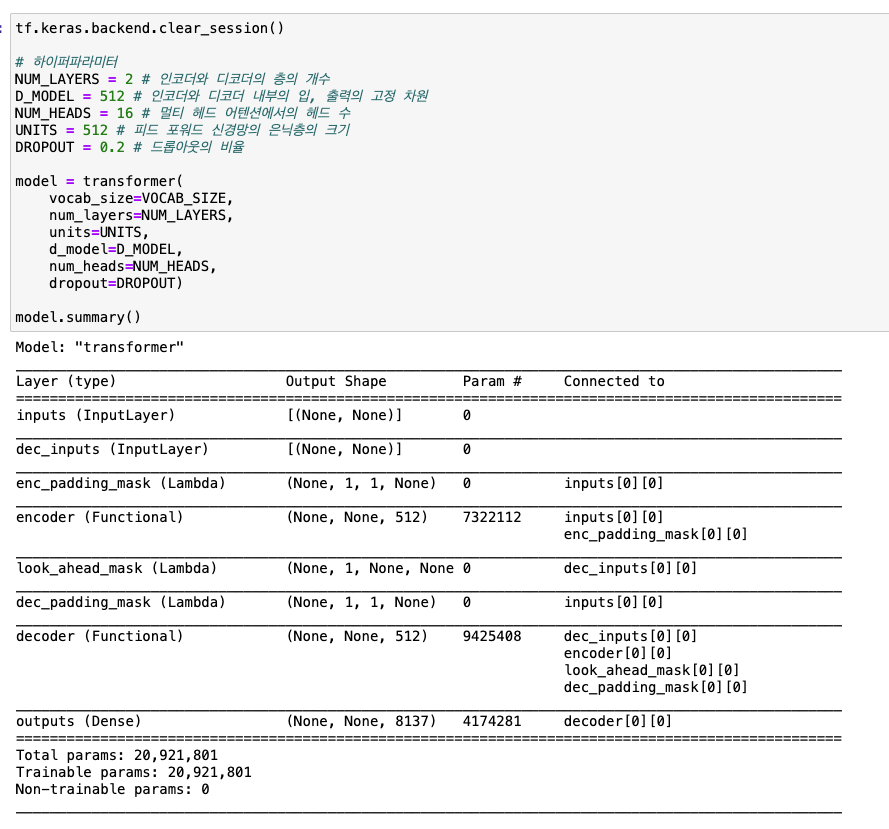
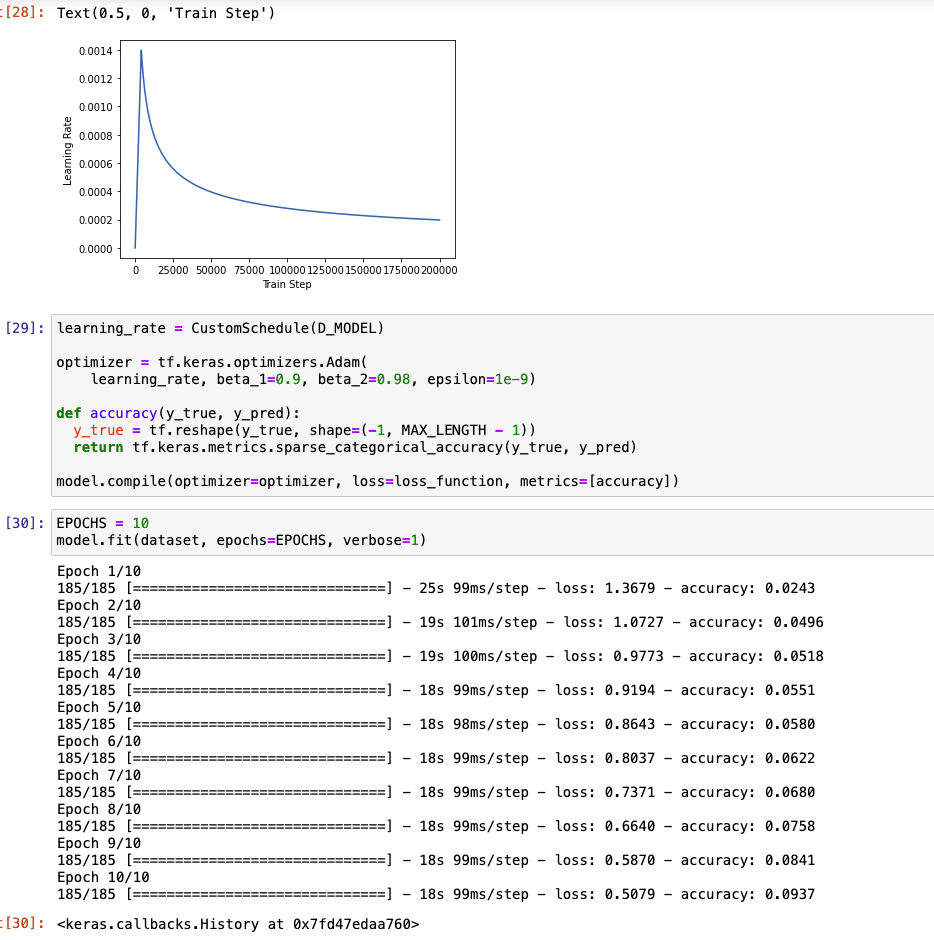
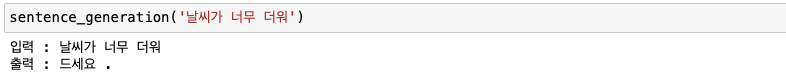

## 3번째 테스트
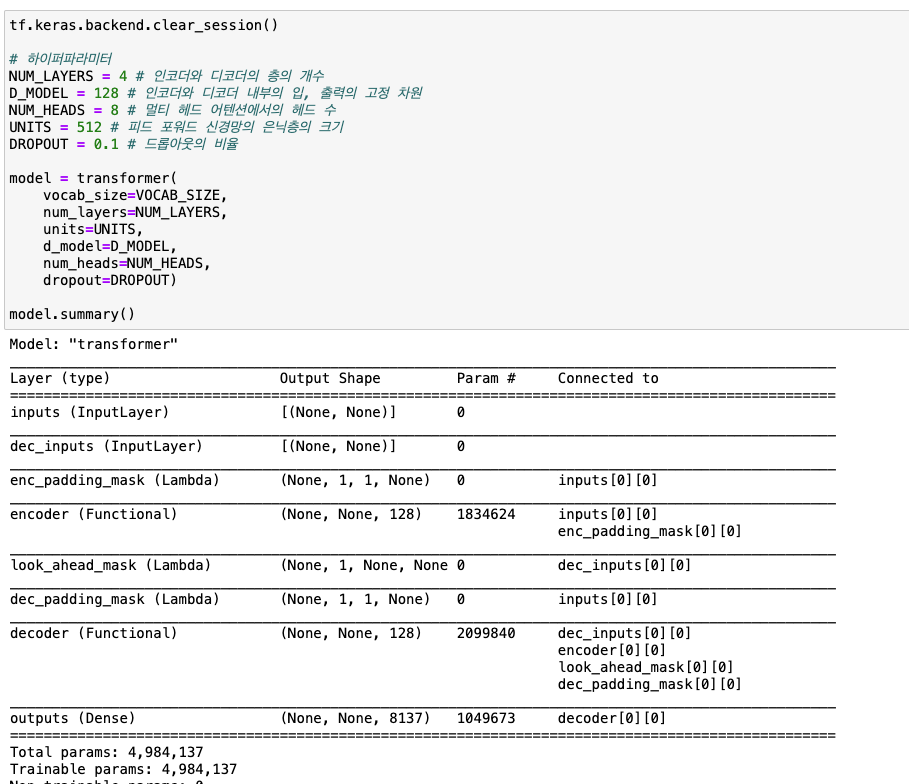
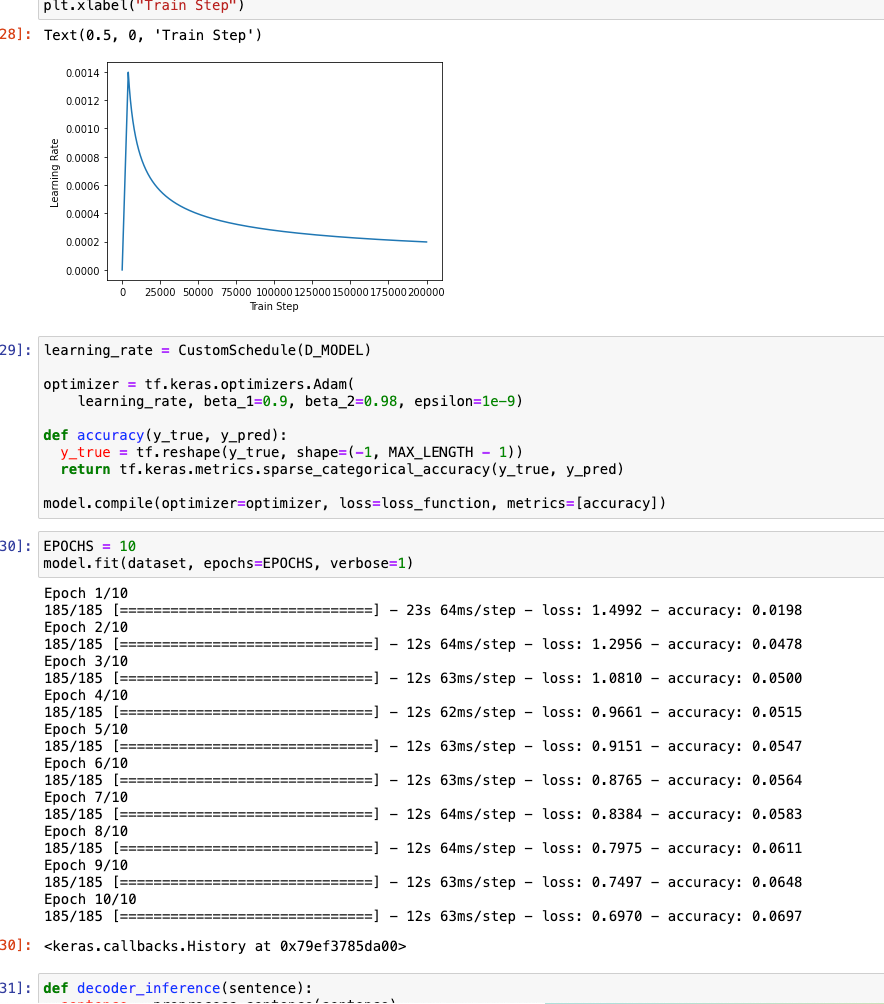
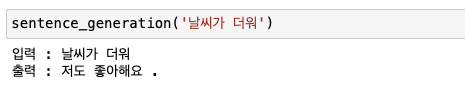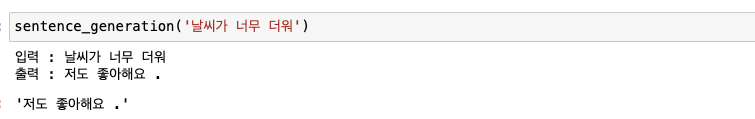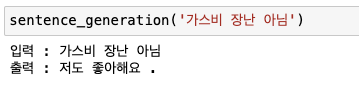

## 4번째 테스트
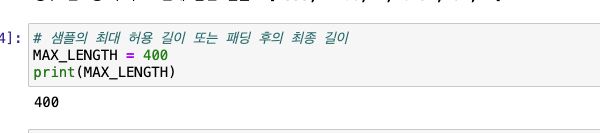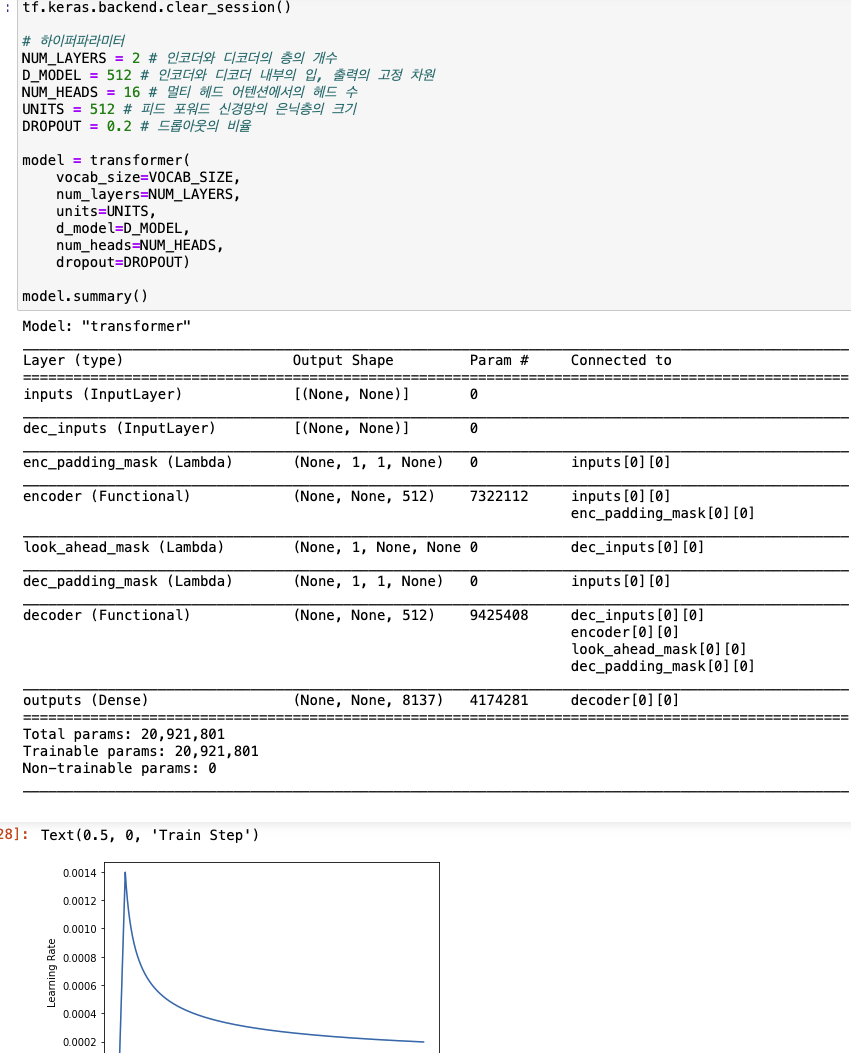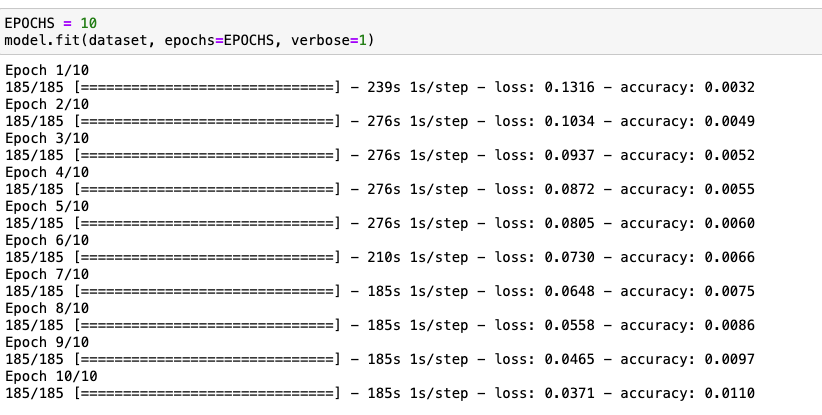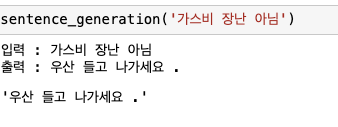

### 5번째 테스트
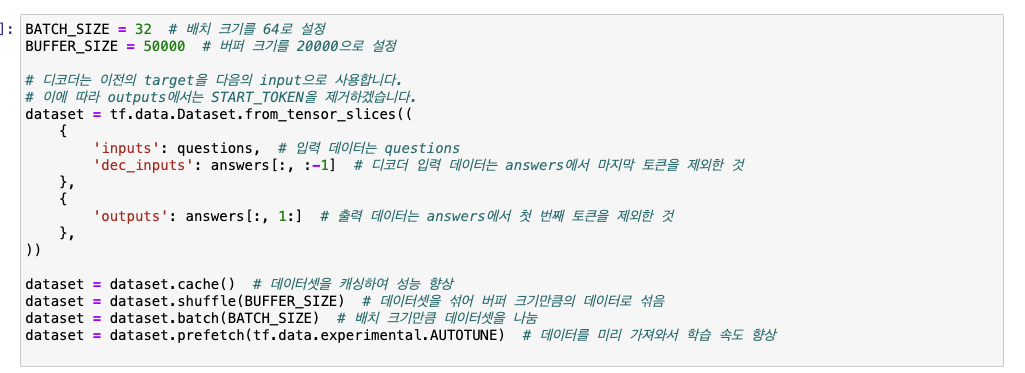
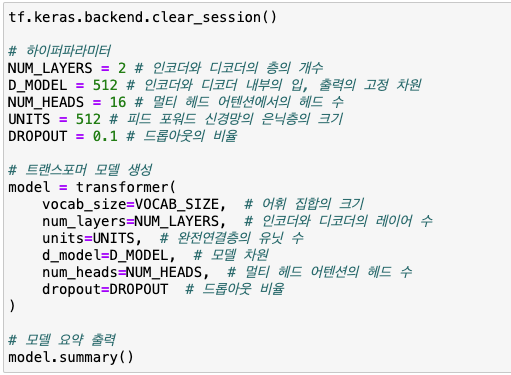
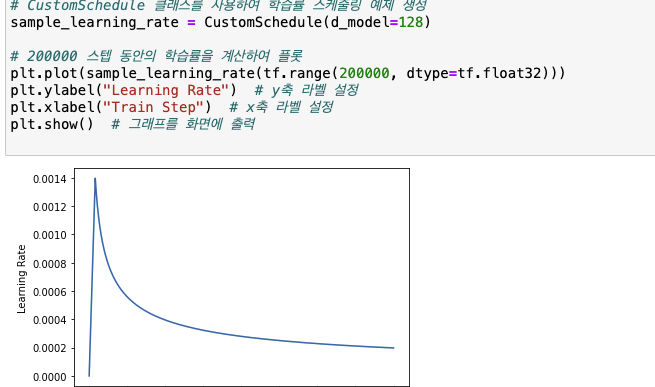
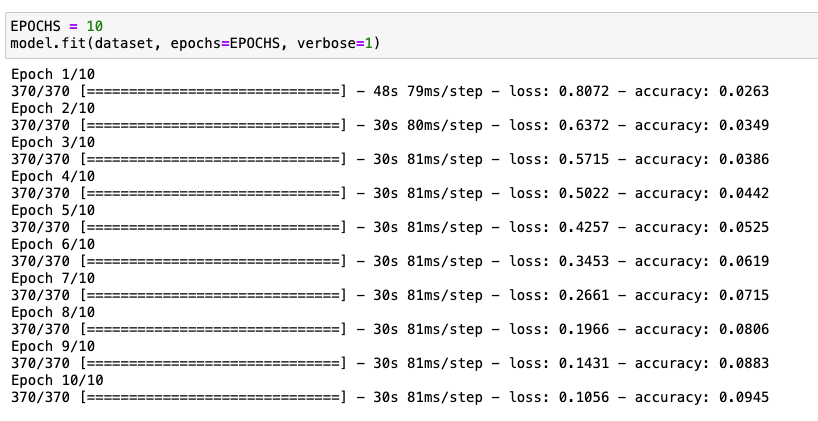
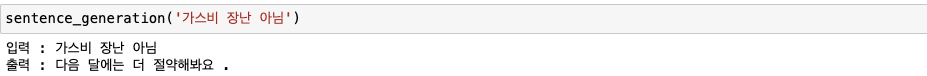
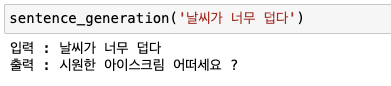
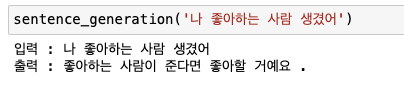
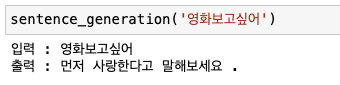
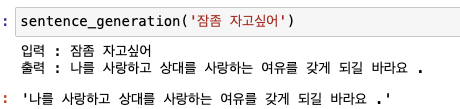

## 6번째 테스트
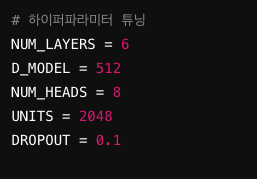
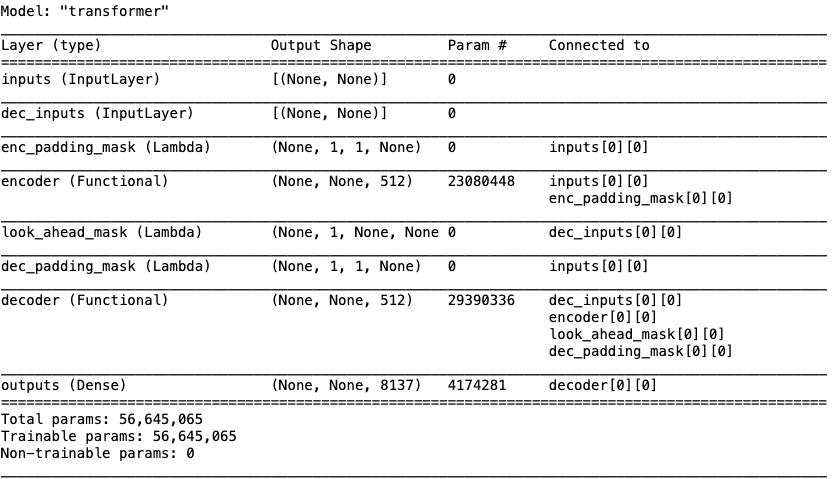
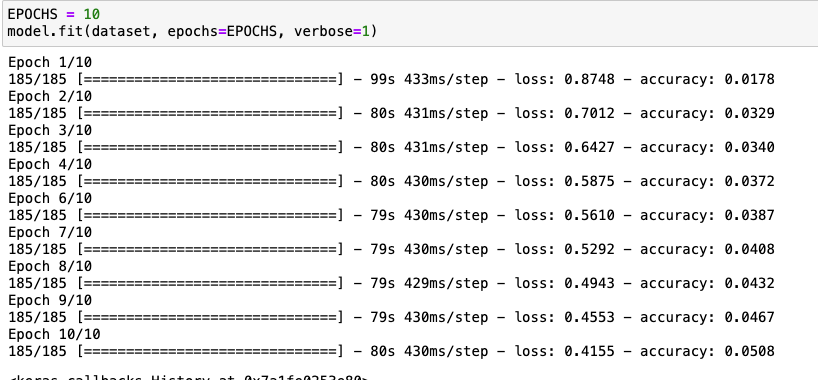
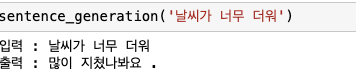

## 7번째 테스트
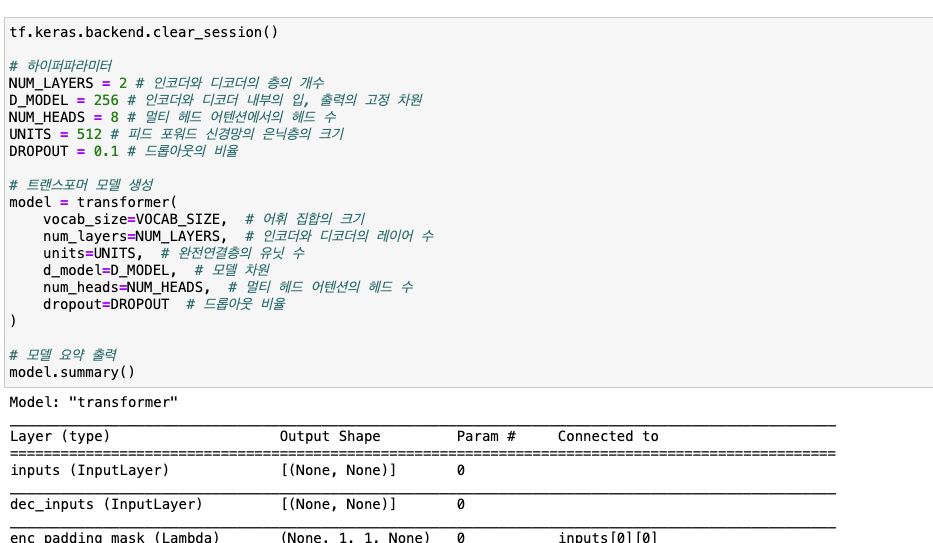
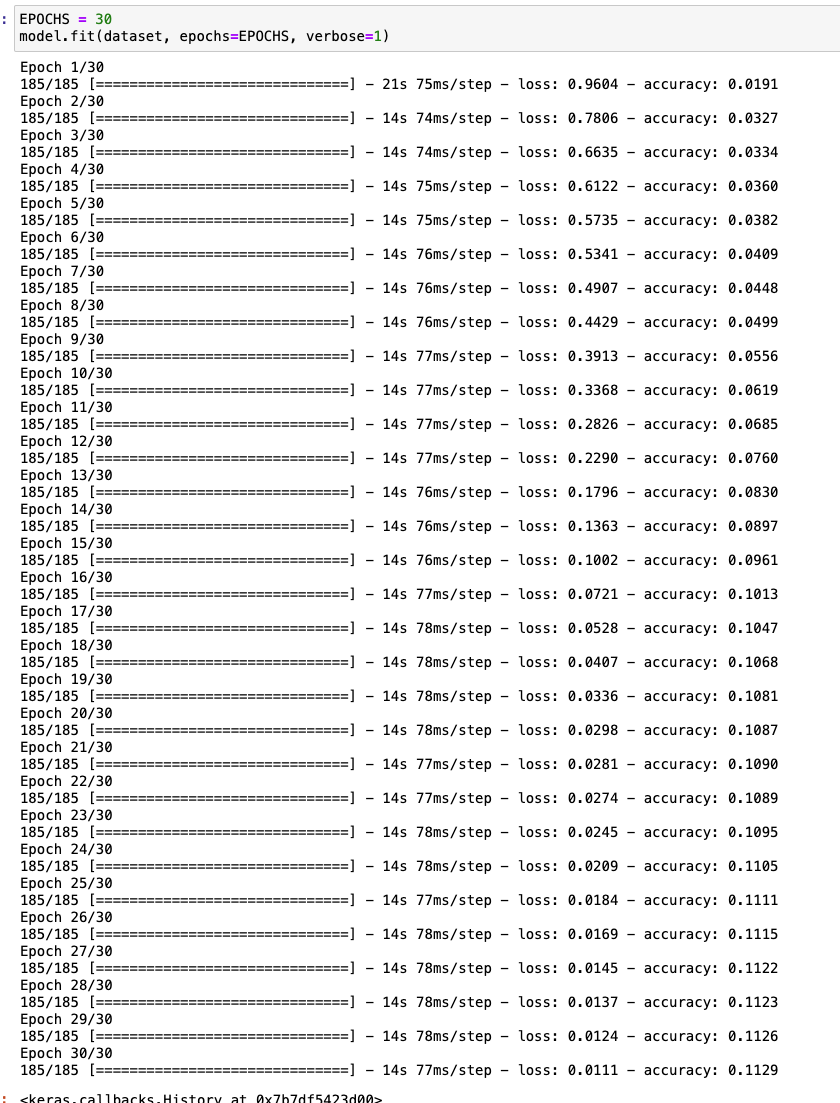
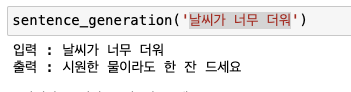
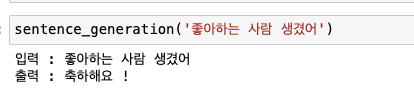
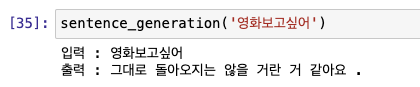
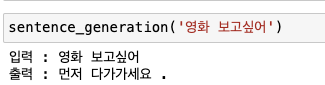
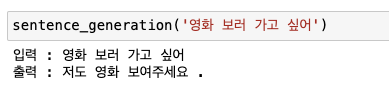
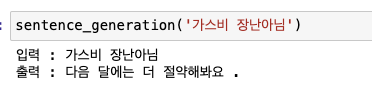
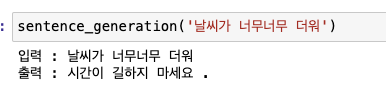
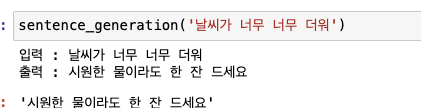
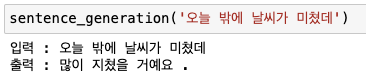

## 8번째 테스트
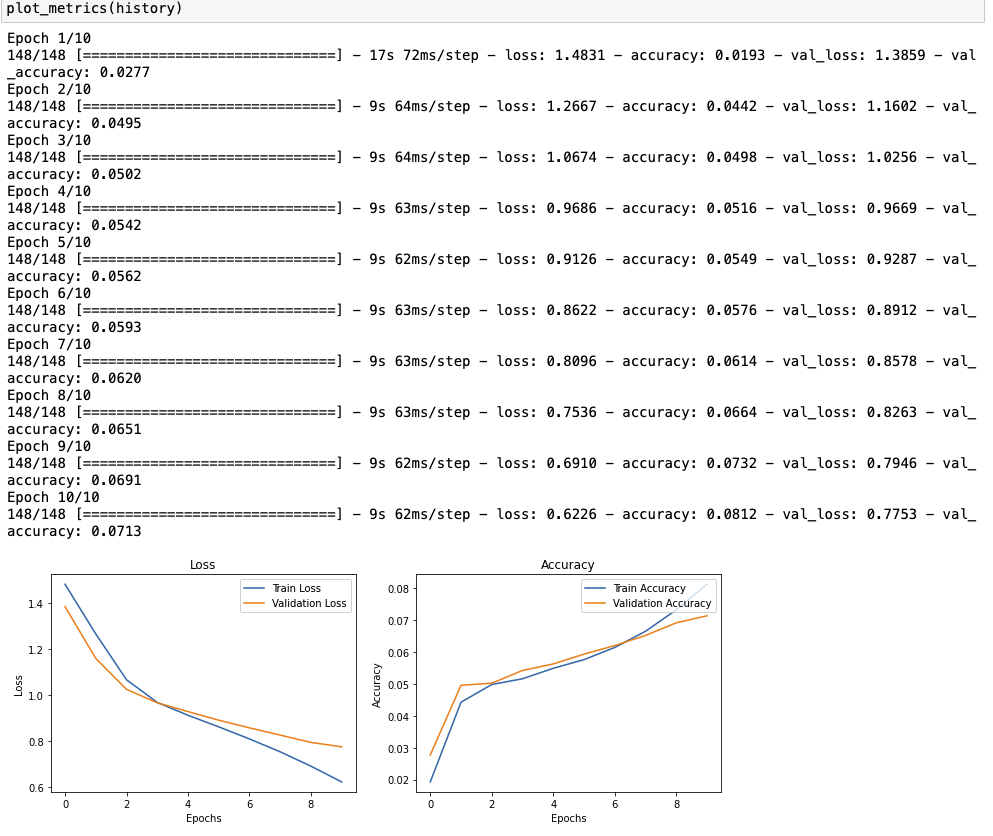
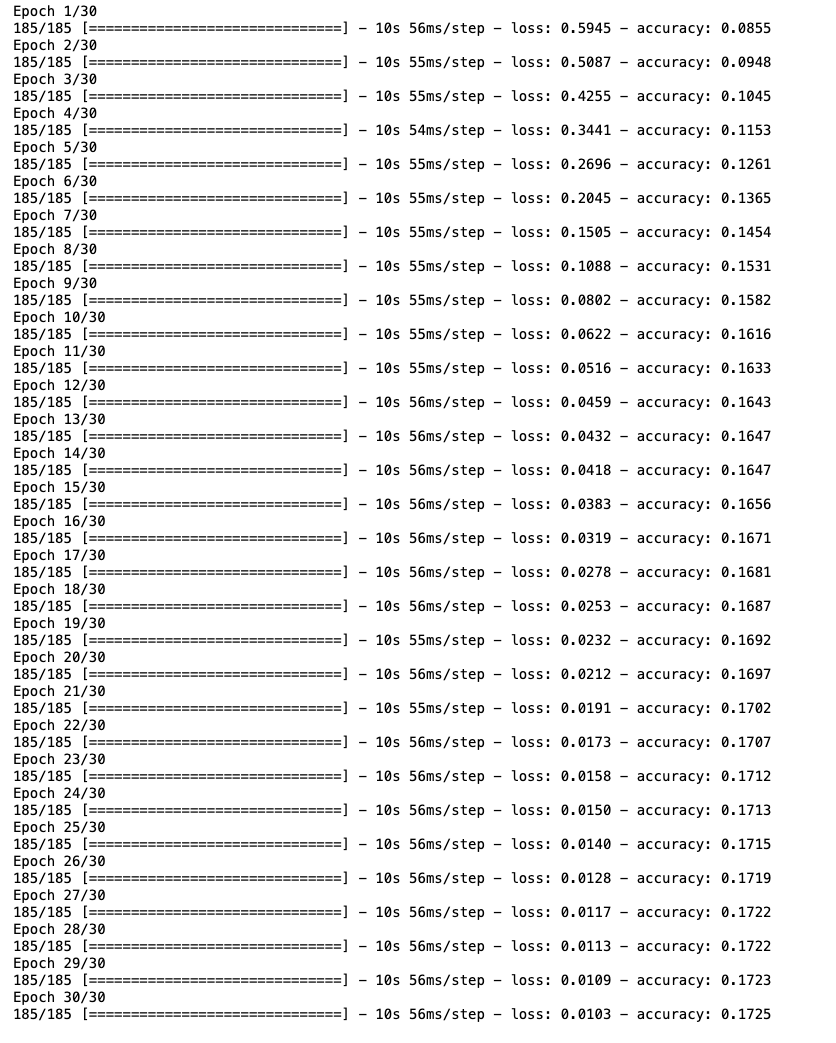
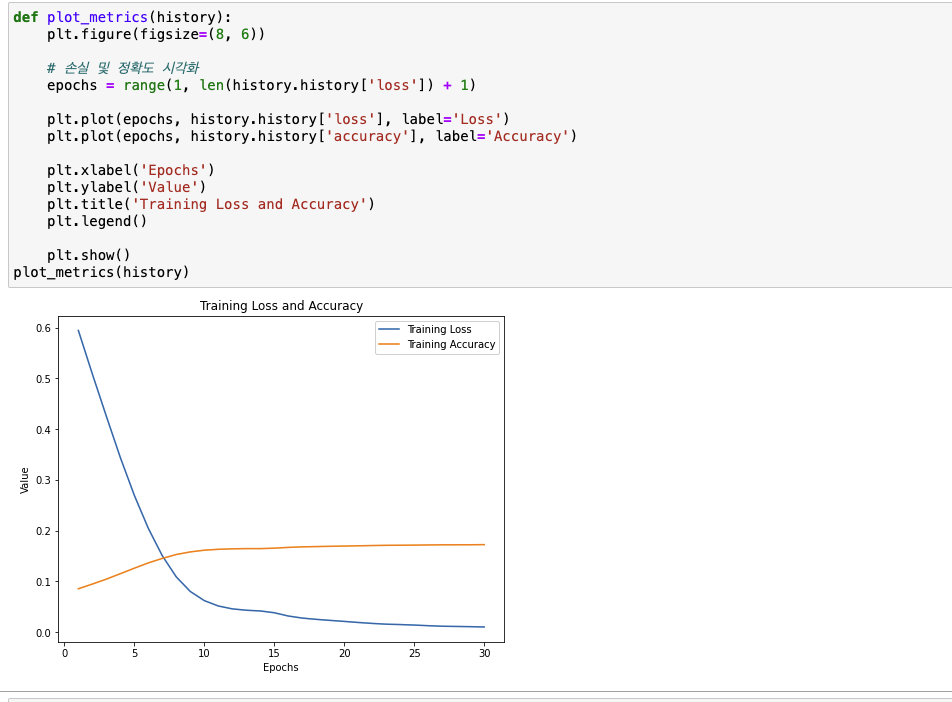
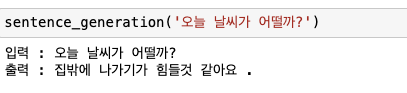

## 튜너 사용
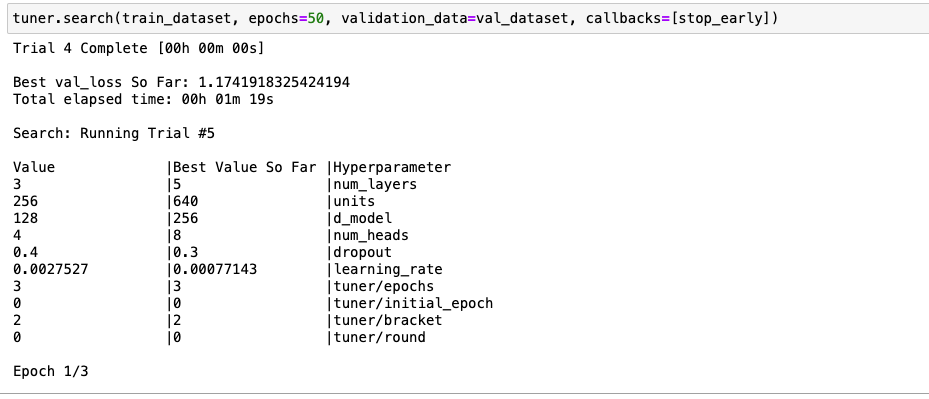
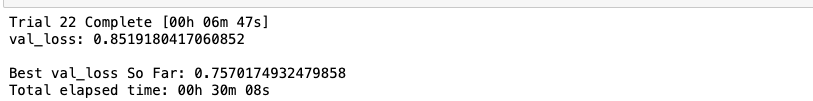
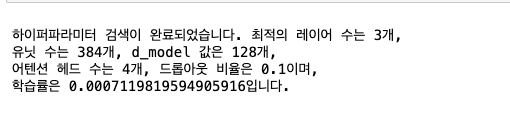
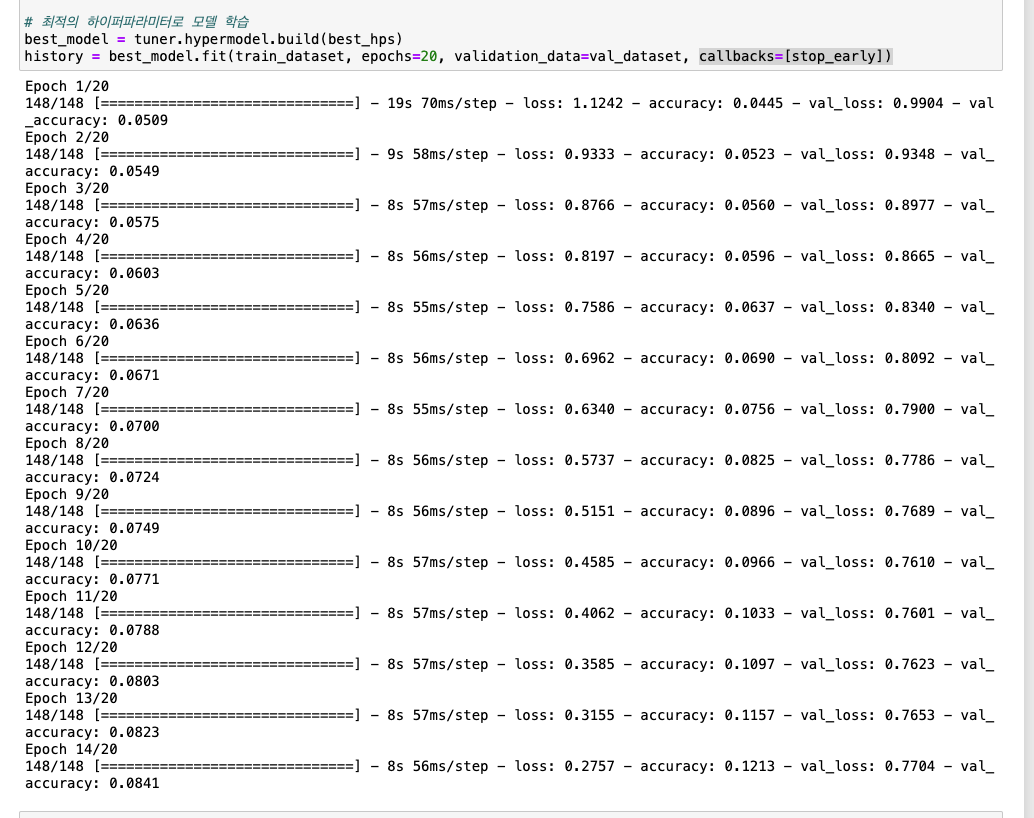
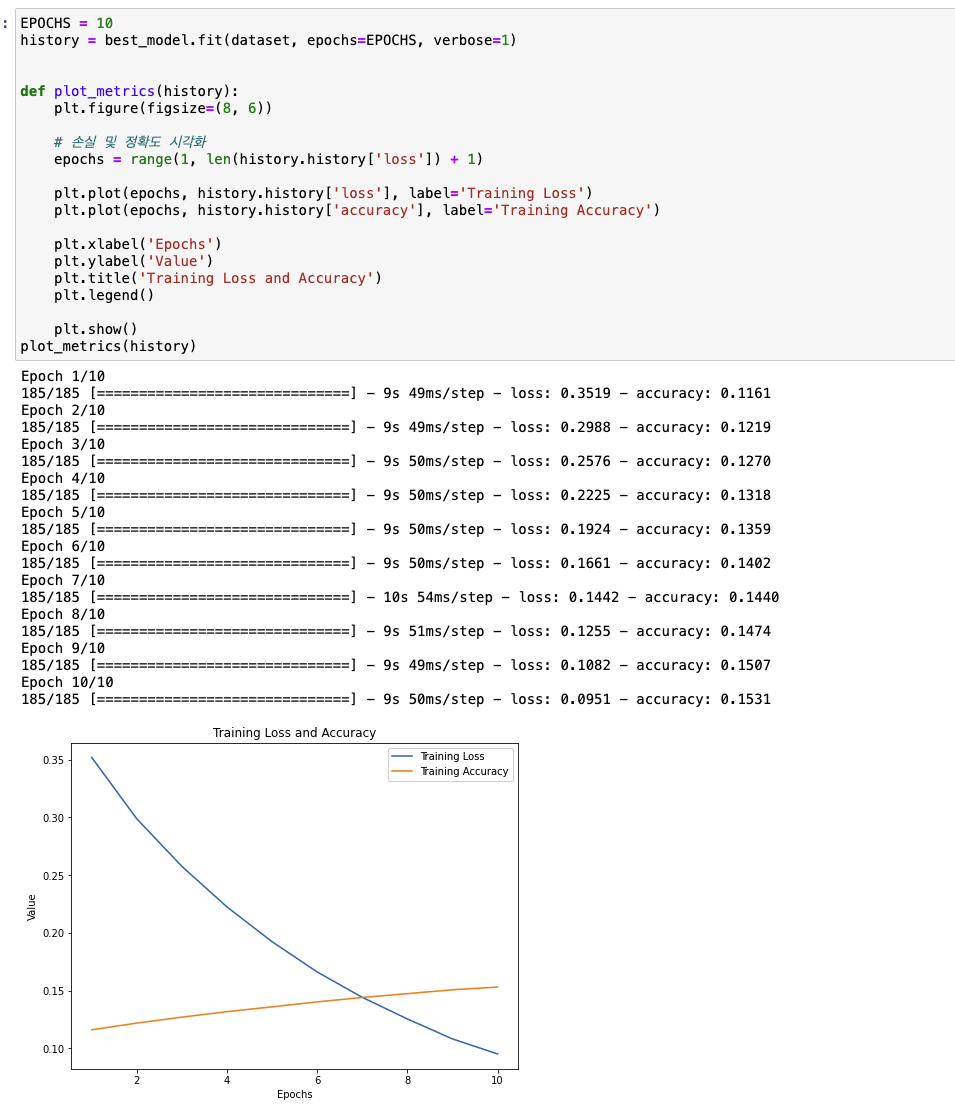
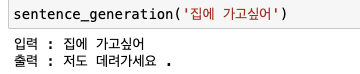
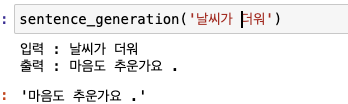

## 형태소 분석기 실패
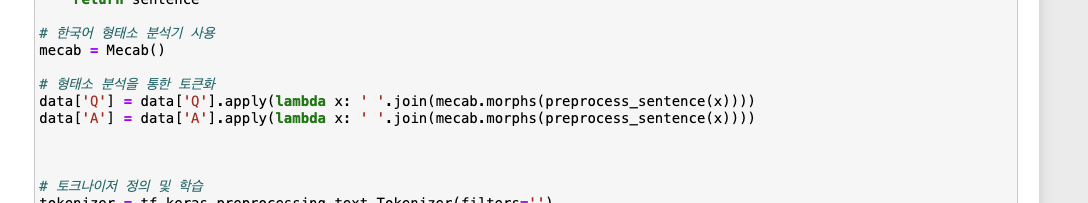
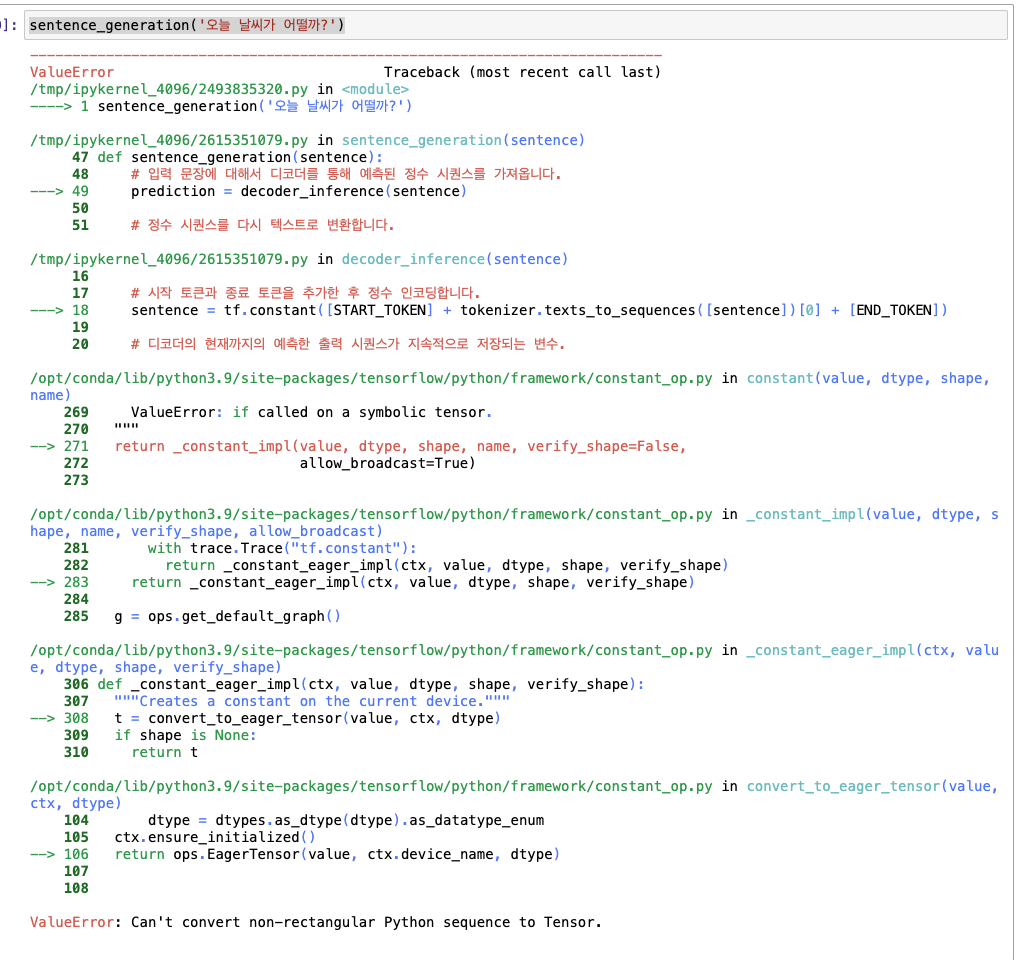

회고
- [ ]  **4. 프로젝트에 대한 회고가 상세히 기록 되어 있나요? (회고, 정리)**
    - [ ]  배운 점 : 트렌스포머 모델을 학습할수 있었다. 키,쿼리가 어떤 동작을 하는지, 인코더와 디코더가 어떻게 진행되는지, 어텐션이 어던식으로 동작                     하는지를 학습할수 있었다.
    - [ ]  아쉬운 점: 모델 튜닝이 원하는 성과를 내지 못했다. 그로 인해 현태소를 진행해보려 했는데 그 생각을 너무 늦게 해서 완료하지 못하고 시간이 끝나버렸다.
    - [ ]  느낀 점 : 아무값이나 건드린다고 되는것이 아닌것을 느꼈다. 좋다고 하는 방식을 여러가지 적용해봤지만 의미적인 변화는 느끼지 못했다.
    - [ ]  어려웠던 점 : 어떤값이 어떤식으로 작동하는지를 확실히 파악하지 못해 테스트가 오래 걸렸다. loss_function도 만져보고 싶었는데 건드리기가 쉽지않았다.